In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from itertools import combinations

import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
from helpers import load_data

dataset = load_data()
data = dataset.data.original

In [4]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

### Train / Test Split

In [5]:
y = (data['readmitted'] == "<30").astype(int)
g = data['patient_nbr']
X = data.drop(columns=['encounter_id', 'readmitted'])

In [6]:
sgkf777 = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=777)

k_fold_split_777 = [test_index for _, test_index in sgkf777.split(X, y, g)]

**NOTE**

For training and validation, we use a 5-fold split (train/test ratio of 4:1), which allows for five separate fittings and corresponding sets of evaluation metrics that are then averaged. `StratifiedGroupKFold` is used with the `patient_nbr` column as the grouping variable to prevent the same patient from appearing in both the training and test sets.

#### Validate k-fold split have non-overlapping patient

In [7]:
k_fold_patient_count = [len(g[test_index].value_counts()) for test_index in k_fold_split_777]
sum(k_fold_patient_count) == len(g.value_counts())

True

#### Validate class proportion is maintained

In [8]:
[float(y[test_index].value_counts(normalize=True)[1]) for test_index in k_fold_split_777]

[0.11378095331310561,
 0.11220550386062166,
 0.1097106424717999,
 0.11309346813361086,
 0.10924124513618677]

### Create secondary split for finetuning

In [9]:
# Avoid using same split for evaluation and finetuning
sgkf888 = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=888)
k_fold_split_888 = [test_index for _, test_index in sgkf888.split(X, y, g)]

**NOTE**

To prevent optimizing evaluation metrics on the same data used for evaluation, we use a separate 5-fold set (generated with a different random seed) for fine-tuning.

### Numeric Features

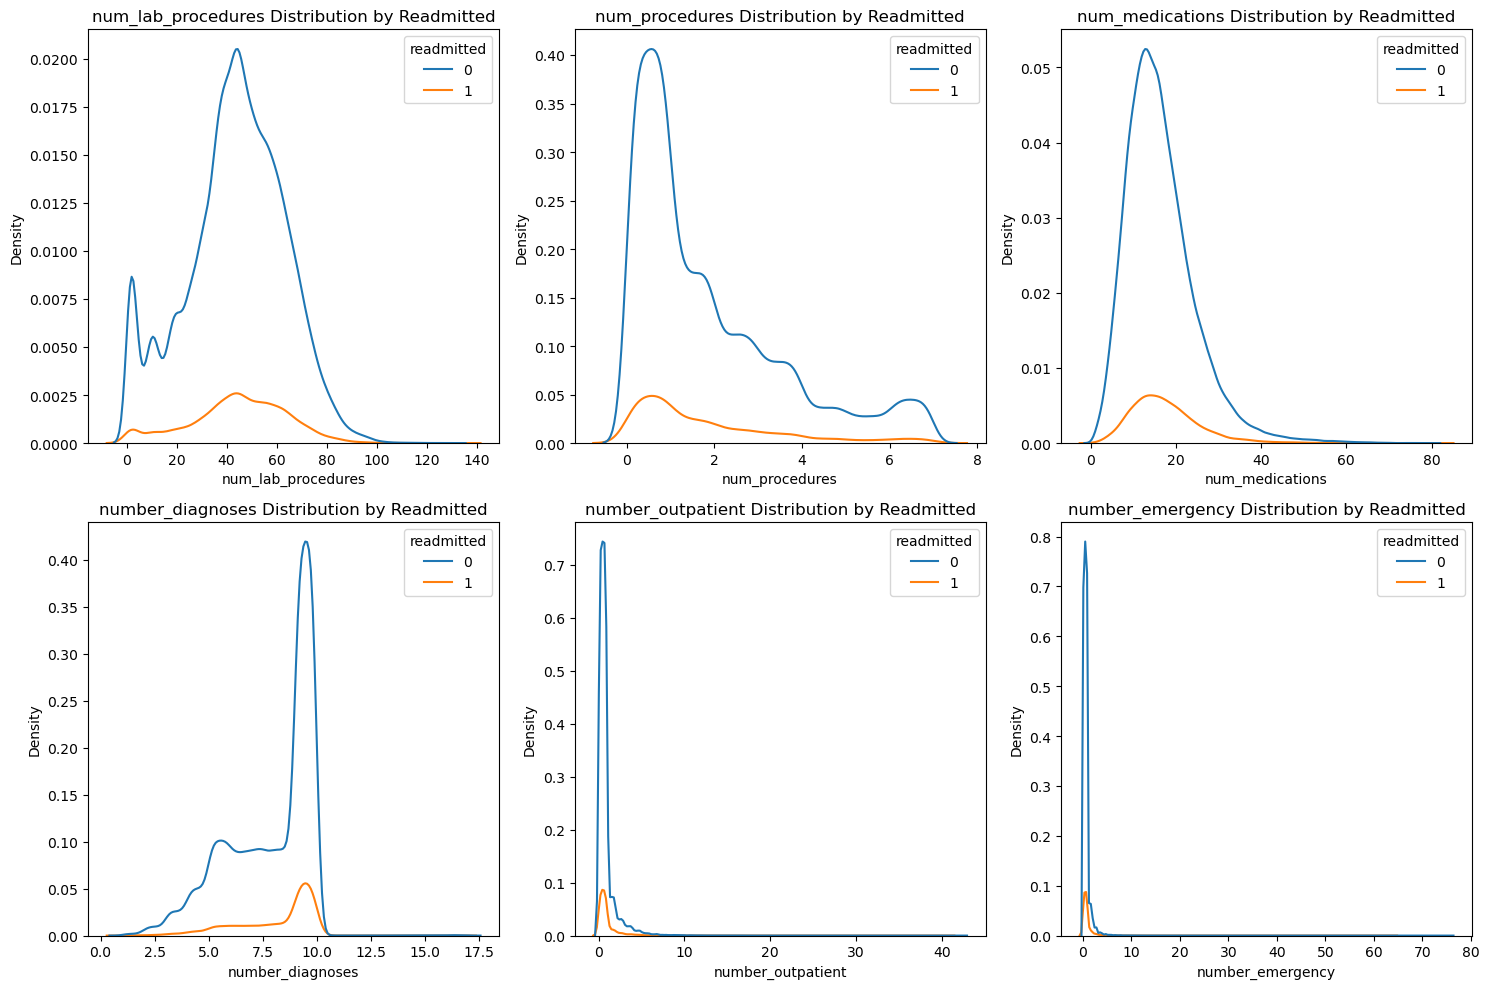

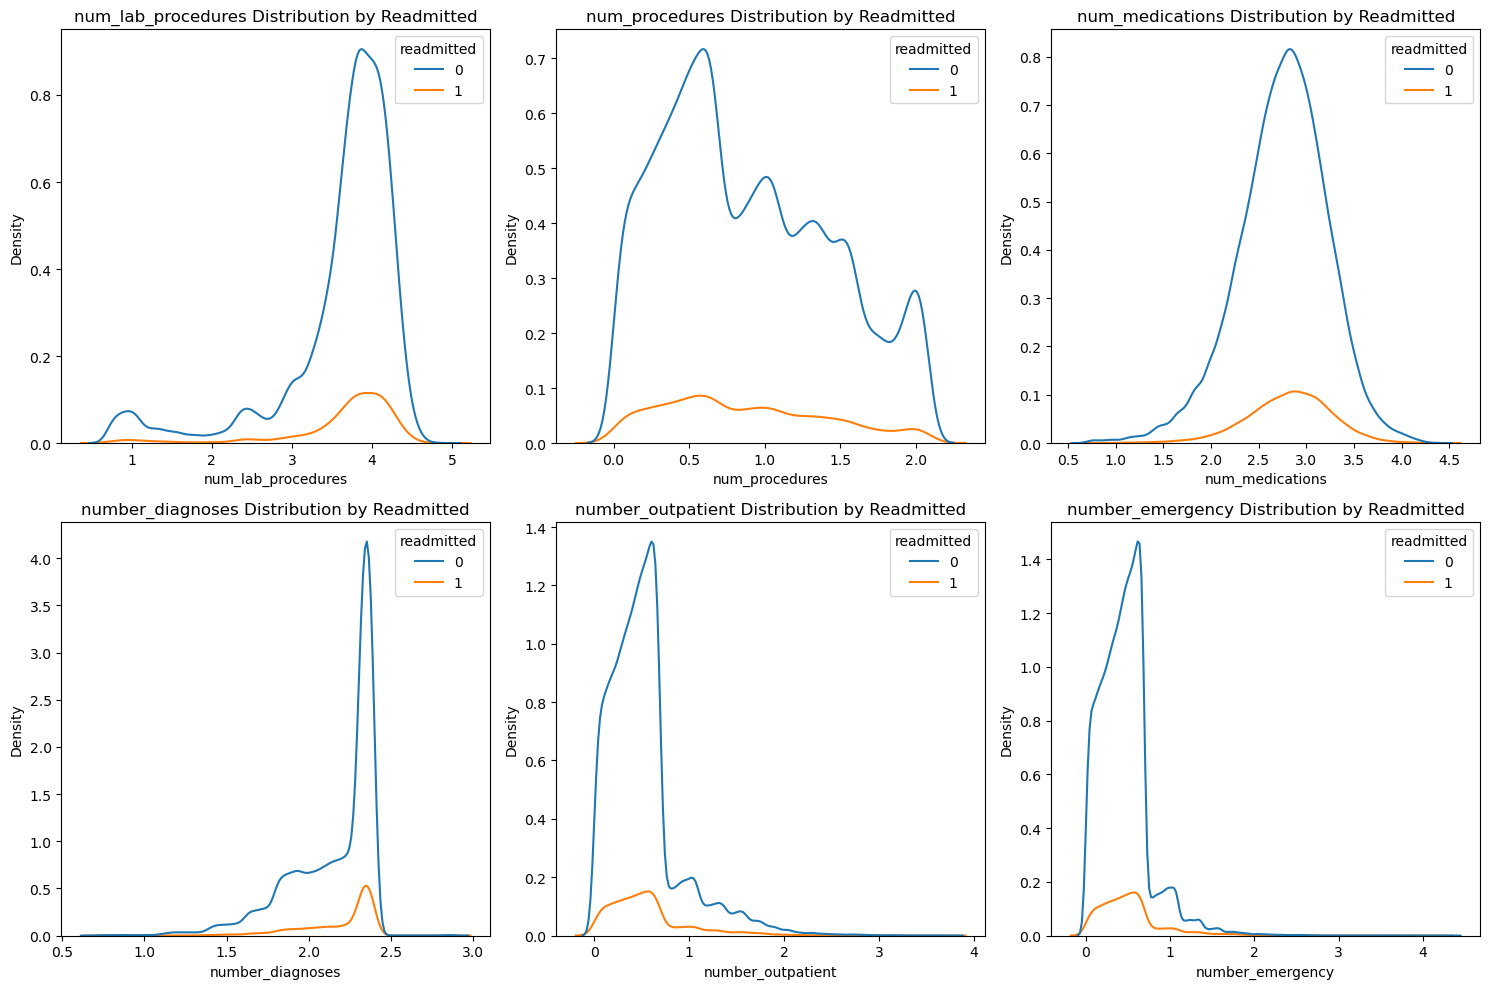

In [10]:
numeric_features = [
    'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'time_in_hospital'
]

def plot_numeric_feature(X, y, log=False):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    jitter = np.random.uniform(0, 1, len(X))

    for ax, feature in zip(axes.ravel(), numeric_features):
        x = np.log(data[feature] + jitter + 1) if log else data[feature] + jitter
        sns.kdeplot(x=x, hue=y, ax=ax)
        ax.set_title(f'{feature} Distribution by Readmitted')

    plt.tight_layout()

plot_numeric_feature(X, y, False)
plot_numeric_feature(X, y, True)


In [11]:
# Create numeric transformer with proper feature names
numeric_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

**NOTE**

All numeric features are natural numbers (one-sided, positive, and typically long-tailed). To reduce skewness, we apply a log-plus-one transformation. The transformed features are then standardized to ensure coefficient comparability.

### Catergorical Feature

In [12]:
categorical_features = [
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'medical_specialty', 'max_glu_serum', 'A1Cresult'
]

categorical_features_with_missing = ['medical_specialty', 'max_glu_serum', 'A1Cresult']
categorical_features_wo_missing = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

for feature in categorical_features:
    X[feature] = X[feature].astype('category')

X['max_glu_serum'] = X['max_glu_serum'].cat.reorder_categories(['Norm', '>200', '>300'])
X['A1Cresult'] = X['A1Cresult'].cat.reorder_categories(['Norm', '>7', '>8'])

In [13]:
# Simple _nan/_None dropping transformer
class NanDroppingTransformer(BaseEstimator, TransformerMixin):
    """
    Simple transformer that drops _nan/_None columns after OneHotEncoder
    """
    
    def __init__(self, base_transformer):
        self.base_transformer = base_transformer
        
    def fit(self, X, y=None):
        self.base_transformer.fit(X, y)
        return self
    
    def transform(self, X):
        # Transform using the base transformer
        transformed = self.base_transformer.transform(X)
        
        # Get feature names
        feature_names = self.base_transformer.get_feature_names_out()
        
        # Create DataFrame
        if hasattr(transformed, 'toarray'):
            transformed = transformed.toarray()
        
        df = pd.DataFrame(transformed, columns=feature_names, index=X.index)
        
        # Drop columns that end with _nan or _None
        nan_columns = [col for col in df.columns if col.endswith('_nan') or col.endswith('_None')]
        if nan_columns:
            df = df.drop(columns=nan_columns)
        
        return df
    
    def get_feature_names_out(self, input_features=None):
        # Get original feature names
        original_names = self.base_transformer.get_feature_names_out()
        # Filter out _nan/_None columns
        filtered_names = [name for name in original_names if not (name.endswith('_nan') or name.endswith('_None'))]
        return filtered_names

# Create transformers that drop _nan/_None columns
categorical_with_missing_transformer = NanDroppingTransformer(
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)
categorical_wo_missing_transformer = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

**NOTE**

For categorical features, we apply one-hot encoding and choose not to drop any columns, as the large sample size makes overfitting less of a concern than underfitting. Columns without missing data have their first class dropped to prevent multicollinearity, while columns with missing data retain all classes so that missing entries correspond to all-zero vectors.

### Demographic Features

In [14]:
demo_features = ['race', 'gender', 'age']

for feature in demo_features:
    X[feature] = X[feature].astype('category')

patient_encounter = data['patient_nbr'].value_counts()
w = 1.0 / data['patient_nbr'].map(patient_encounter)

# Sort race categories by frequency
race_sorted = w.groupby(data['race']).sum().sort_values(ascending=False)
X['race'] = X['race'].cat.reorder_categories(list(race_sorted.index))

# Assign missing value race to the mode
mode_race = race_sorted.index[0]
X['race'] = X['race'].fillna(mode_race)

gender_sorted = w.groupby(data['gender']).sum().sort_values(ascending=False)
# Assign missing/unknown gender to the mode and remove Unknown/Invalid category
mode_gender = gender_sorted.index[0]
X['gender'] = X['gender'].replace('Unknown/Invalid', mode_gender)
X['gender'] = X['gender'].cat.reorder_categories(['Female', 'Male'])


In [15]:
class DemographicInteractionTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that:
    1. Applies one-hot encoding to demographic features
    2. Creates pairwise interactions between original demographic features (not between one-hot encoded features)
    """
    
    def __init__(self):
        self.onehot_encoders = {}
        self.feature_names_ = None
        
    def fit(self, X, y=None):
        # Fit one-hot encoders for each demographic feature
        for feature in X.columns:
            # Get the categories in the order they appear in the pandas Categorical
            if hasattr(X[feature].dtype, 'categories'):
                categories = [X[feature].dtype.categories.tolist()]
            else:
                categories = 'auto'
            
            encoder = OneHotEncoder(
                handle_unknown='ignore', 
                drop='first', 
                sparse_output=False,
                categories=categories
            )
            encoder.fit(X[[feature]])
            self.onehot_encoders[feature] = encoder
        
        # Generate feature names for the final output
        self._generate_feature_names(X)
        return self
    
    def transform(self, X):
        # Apply one-hot encoding to each demographic feature
        encoded_features = []
        feature_names = []
        
        for feature in X.columns:
            encoded = self.onehot_encoders[feature].transform(X[[feature]])
            encoded_features.append(encoded)
            
            # Get feature names for this feature
            feature_names.extend(self.onehot_encoders[feature].get_feature_names_out([feature]))
        
        # Create pairwise interactions between original demographic features
        interaction_features = []
        interaction_names = []
        
        for feat1, feat2 in combinations(X.columns, 2):
            # Get the one-hot encoded features for both original features
            encoded1 = self.onehot_encoders[feat1].transform(X[[feat1]])
            encoded2 = self.onehot_encoders[feat2].transform(X[[feat2]])
            
            # Create interactions between all pairs of one-hot encoded features
            for i in range(encoded1.shape[1]):
                for j in range(encoded2.shape[1]):
                    interaction = encoded1[:, i] * encoded2[:, j]
                    interaction_features.append(interaction.reshape(-1, 1))
                    
                    # Get feature names for the interaction
                    feat1_name = self.onehot_encoders[feat1].get_feature_names_out([feat1])[i]
                    feat2_name = self.onehot_encoders[feat2].get_feature_names_out([feat2])[j]
                    interaction_names.append(f"{feat1_name} x {feat2_name}")
        
        # Combine all features
        all_features = encoded_features + interaction_features
        result = np.hstack(all_features)
        
        return result
    
    def _generate_feature_names(self, X):
        """Generate feature names for the final output"""
        feature_names = []
        
        # Add one-hot encoded feature names
        for feature in X.columns:
            feature_names.extend(self.onehot_encoders[feature].get_feature_names_out([feature]))
        
        # Add interaction feature names
        for feat1, feat2 in combinations(X.columns, 2):
            feat1_names = self.onehot_encoders[feat1].get_feature_names_out([feat1])
            feat2_names = self.onehot_encoders[feat2].get_feature_names_out([feat2])
            
            for name1 in feat1_names:
                for name2 in feat2_names:
                    feature_names.append(f"{name1} x {name2}")
        
        self.feature_names_ = feature_names
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

# Create the demographic transformer
demo_transformer = DemographicInteractionTransformer()

**NOTE**

Demographic features receive separate treatment, as we also aim to model interactions between demographic groups (e.g., race × gender, gender × age).

### Medication features

In [16]:
medication_features = data.columns[24:47]
medication_prevalence = (data[medication_features] != 'No').sum().sort_values(ascending=False)
sorted_medication_features = list(medication_prevalence.index[:10])

medication_transformer = FunctionTransformer(
    lambda X: pd.DataFrame({
        **{col + '_yes': X[col].isin(['Down', 'Steady', 'Up']).astype(int) 
            for col in X.columns},
        **{col + '_up': (X[col] == 'Up').astype(int)
            for col in X.columns}
    })
)

medication_transformer.get_feature_names_out = lambda: [f + '_yes' for f in sorted_medication_features] + [f + '_up' for f in sorted_medication_features]

**NOTE**

The four medication status classes (No, Down, Steady, Up) are collapsed into two columns per feature: (Yes/No) and (Increase/Not increased).

### Dianogsis Features

In [17]:
diagnosis_features = ['diag_1', 'diag_2', 'diag_3', 'patient_nbr']

class DiagnosisPCATransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that:
    1. Combines diag_1, diag_2, diag_3 with OR operation
    2. Groups by patient and combines diagnoses using max operation
    3. Applies PCA and returns first 200 components
    """
    
    def __init__(self, n_components=200):
        self.n_components = n_components    # For returning components in transform
        self.diag_categories_ = None
        self.pca_ = None
        
    def fit(self, X, y=None):
        """
        Fit the transformer on training data
        X should contain diag_1, diag_2, diag_3 columns and patient_nbr column
        """
        # Get all unique diagnosis categories from training data
        all_diag_categories = pd.concat([X['diag_1'], X['diag_2'], X['diag_3']]).unique()
        # Remove None/NaN values
        all_diag_categories = all_diag_categories[pd.notna(all_diag_categories)]
        
        # Convert to categorical with all possible categories (following EDA approach)
        diag_1_cat = pd.Categorical(X['diag_1'], categories=all_diag_categories)
        diag_2_cat = pd.Categorical(X['diag_2'], categories=all_diag_categories)
        diag_3_cat = pd.Categorical(X['diag_3'], categories=all_diag_categories)
        
        # Create one-hot encodings for each diagnosis column
        diag_1_oh = pd.get_dummies(diag_1_cat, dtype=int)
        diag_2_oh = pd.get_dummies(diag_2_cat, dtype=int)
        diag_3_oh = pd.get_dummies(diag_3_cat, dtype=int)
        
        # Combine diagnosis one-hot encodings with OR operation
        diag_oh_combined = diag_1_oh + diag_2_oh + diag_3_oh
        
        # Get the most frequent diagnosis
        most_freq_diag = diag_oh_combined.sum().sort_values(ascending=False).index
        
        # Create dataframe with patient numbers and diagnosis one-hot encodings
        patient_diag_oh = pd.concat([X['patient_nbr'], diag_oh_combined], axis=1)
        
        # Group by patient and combine using max (equivalent to OR for binary values)
        patient_grouped_diag_oh = patient_diag_oh.groupby('patient_nbr').max()
        patient_grouped_diag_oh = (patient_grouped_diag_oh > 0).astype(int)
        
        # Fit PCA on patient-grouped diagnosis data
        # Number of components should be based on the number of diagnosis categories
        n_components = len(most_freq_diag)
        self.diag_categories_ = list(most_freq_diag)
        self.pca_ = PCA(n_components=n_components)
        self.pca_.fit(patient_grouped_diag_oh[most_freq_diag])
        
        return self
    
    def transform(self, X):
        """
        Transform the data using the fitted transformer
        X should contain diag_1, diag_2, diag_3 columns
        """
        # Convert to categorical with trained categories (following EDA approach)
        diag_1_cat = pd.Categorical(X['diag_1'], categories=self.diag_categories_)
        diag_2_cat = pd.Categorical(X['diag_2'], categories=self.diag_categories_)
        diag_3_cat = pd.Categorical(X['diag_3'], categories=self.diag_categories_)
        
        # Create one-hot encodings for each diagnosis column
        # Unseen values will be NaN and get dropped, resulting in all zeros
        diag_1_oh = pd.get_dummies(diag_1_cat, dtype=int)
        diag_2_oh = pd.get_dummies(diag_2_cat, dtype=int)
        diag_3_oh = pd.get_dummies(diag_3_cat, dtype=int)
        
        # Combine diagnosis one-hot encodings with OR operation (using max for binary consistency)
        diag_oh_combined = np.maximum(diag_1_oh, np.maximum(diag_2_oh, diag_3_oh))
    
        
        # Apply the fitted PCA transformation directly to encounter-level data
        pca_result = self.pca_.transform(diag_oh_combined)
        
        # Return only the first n_pc_return components
        return pca_result[:, :self.n_components]

    def get_feature_names_out(self, input_features=None):
        return [f"diag_PC{i}" for i in range(self.n_components)]

diagnosis_transformer = DiagnosisPCATransformer(n_components=200)

**NOTE**

The diagnosis feature, originally containing over 900 classes spread across three columns (primary, secondary, and additional), is consolidated into a single set of binary indicators and then reduced to 200 components using PCA.

### Compose

In [18]:
# Create the complete preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Numeric features: log transform + standardize
        ('numeric', numeric_transformer, numeric_features),

        # Categorical features: one-hot encoding
        ('categorical_wo_missing', categorical_wo_missing_transformer, categorical_features_wo_missing),
        ('categorical_with_missing', categorical_with_missing_transformer, categorical_features_with_missing),
        
        # Demographic features: one-hot + interactions
        ('demo', demo_transformer, demo_features),
        
        # Medication features: binary encoding
        ('medication', medication_transformer, sorted_medication_features),
        
        # Diagnosis features: PCA with 200 components
        ('diagnosis', diagnosis_transformer, diagnosis_features)
    ],
    remainder='drop'  # Drop any remaining columns
)

def get_feature_names_out(self):
    """Get feature names after the preprocessor has been fitted"""
    feature_names = []
    
    for name, transformer, features in self.transformers_:
        # Handle specific transformer types
        if name == 'numeric':
            # For numeric transformer, return input features
            feature_names.extend(features)
            
        elif name == 'medication':
            # For medication transformer, return input features with _yes and _up
            med_names = [f + '_yes' for f in features] + [f + '_up' for f in features]
            feature_names.extend(med_names)
            
        elif name == 'remainder':
            # For remainder transformer, return empty list
            pass
            
        else:
            # For all other transformers, call their own get_feature_names_out method
            if hasattr(transformer, 'get_feature_names_out'):
                try:
                    names = transformer.get_feature_names_out()
                    feature_names.extend(names)
                except Exception as e:
                    raise e
    
    return feature_names

preprocessor.get_feature_names_out = get_feature_names_out.__get__(preprocessor)

**NOTE**

All preprocessors implement the `get_feature_names_out` method, allowing processed feature columns to be mapped back to their original columns or class labels for coefficient interpretability.

### Sanity Check

*No need to include this part in report*

In [19]:
### Apply Preprocessor to Whole Dataset and Sanity Check

print("=== APPLYING PREPROCESSOR TO WHOLE DATASET ===")

# Apply preprocessor to the entire dataset
print("Fitting and transforming preprocessor on entire dataset...")
X_processed = preprocessor.fit_transform(X)

print(f"Original data shape: {X.shape}")
print(f"Processed data shape: {X_processed.shape}")

# Get feature names for analysis
feature_names = preprocessor.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")

# Sanity check: Analyze numeric vs binary features
print(f"\n=== SANITY CHECK ===")

# Identify numeric features (first 8 features should be numeric)
numeric_feature_names = feature_names[:8]  # First 8 are numeric features
numeric_data = X_processed[:, :8]

print(f"Numeric features: {numeric_feature_names}")
print(f"Numeric data shape: {numeric_data.shape}")

# Check numeric features: mean should be ~0, std should be ~1
numeric_means = numeric_data.mean(axis=0)
numeric_stds = numeric_data.std(axis=0)

print(f"\nNumeric features statistics:")
for i, (name, mean, std) in enumerate(zip(numeric_feature_names, numeric_means, numeric_stds)):
    print(f"  {name}: mean={mean:.4f}, std={std:.4f}")

# Check if means are close to 0 and stds are close to 1
mean_close_to_zero = np.allclose(numeric_means, 0, atol=0.1)
std_close_to_one = np.allclose(numeric_stds, 1, atol=0.1)

print(f"\n✅ Numeric features mean close to 0: {mean_close_to_zero}")
print(f"✅ Numeric features std close to 1: {std_close_to_one}")

# Identify binary features (categorical/medication features, excluding PCA)
# Binary features are between numeric (8) and PCA (last 200)
binary_data = X_processed[:, 8:-200]
binary_feature_names = feature_names[8:-200]

print(f"\nBinary features count: {binary_data.shape[1]}")
print(f"Binary feature names preview: {binary_feature_names[:10]}")

# Check binary features: values should be between 0 and 1
binary_min = binary_data.min()
binary_max = binary_data.max()
binary_means = binary_data.mean(axis=0)

print(f"\nBinary features statistics:")
print(f"  Min value: {binary_min:.4f}")
print(f"  Max value: {binary_max:.4f}")
print(f"  Mean of means: {binary_means.mean():.4f}")

# Check if all values are between 0 and 1
values_in_range = (binary_data >= 0).all() and (binary_data <= 1).all()
means_in_range = (binary_means >= 0).all() and (binary_means <= 1).all()

print(f"\n✅ Binary features values in [0,1]: {values_in_range}")
print(f"✅ Binary features means in [0,1]: {means_in_range}")

# Identify PCA features (last 200 features)
pca_data = X_processed[:, -200:]
pca_feature_names = feature_names[-200:]

print(f"\nPCA features count: {pca_data.shape[1]}")
print(f"PCA feature names preview: {pca_feature_names[:5]}")

# Overall data quality check
print(f"\n=== OVERALL DATA QUALITY ===")
print(f"NaN values: {np.isnan(X_processed).sum()}")
print(f"Infinite values: {np.isinf(X_processed).sum()}")
print(f"Overall min: {X_processed.min():.4f}")
print(f"Overall max: {X_processed.max():.4f}")
print(f"Overall mean: {X_processed.mean():.4f}")
print(f"Overall std: {X_processed.std():.4f}")

print(f"\n✅ Preprocessor sanity check completed!")


=== APPLYING PREPROCESSOR TO WHOLE DATASET ===
Fitting and transforming preprocessor on entire dataset...
Original data shape: (101766, 48)
Processed data shape: (101766, 417)
Number of features: 417

=== SANITY CHECK ===
Numeric features: ['num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'number_outpatient', 'number_emergency', 'number_inpatient', 'time_in_hospital']
Numeric data shape: (101766, 8)

Numeric features statistics:
  num_lab_procedures: mean=-0.0000, std=1.0000
  num_procedures: mean=-0.0000, std=1.0000
  num_medications: mean=-0.0000, std=1.0000
  number_diagnoses: mean=0.0000, std=1.0000
  number_outpatient: mean=-0.0000, std=1.0000
  number_emergency: mean=-0.0000, std=1.0000
  number_inpatient: mean=-0.0000, std=1.0000
  time_in_hospital: mean=0.0000, std=1.0000

✅ Numeric features mean close to 0: True
✅ Numeric features std close to 1: True

Binary features count: 209
Binary feature names preview: ['admission_type_id_2', 'admission_type

In [20]:
print("=== PCA-SPECIFIC SANITY CHECKS ===")

# 1. Check variance distribution across components
pca_vars = pca_data.var(axis=0)
print(f"Variance of first 5 components: {pca_vars[:5]}")
print(f"Variance of last 5 components: {pca_vars[-5:]}")
print(f"Variance ratio (first/last): {pca_vars[0]/pca_vars[-1]:.2f}")

# 2. Check for zero variance components
zero_var_components = (pca_vars == 0).sum()
print(f"Zero variance components: {zero_var_components}")

# 3. Check orthogonality (correlation between components should be low)
pca_corr_matrix = np.corrcoef(pca_data.T)
# Remove diagonal (self-correlation = 1)
off_diagonal = pca_corr_matrix[np.triu_indices_from(pca_corr_matrix, k=1)]
max_correlation = np.abs(off_diagonal).max()
mean_correlation = np.abs(off_diagonal).mean()

print(f"Max correlation between components: {max_correlation:.4f}")
print(f"Mean correlation between components: {mean_correlation:.4f}")

# 4. Check component magnitude distribution
pca_abs_means = np.abs(pca_data.mean(axis=0))
pca_abs_stds = pca_data.std(axis=0)

print(f"Component magnitude statistics:")
print(f"  Mean of absolute means: {pca_abs_means.mean():.4f}")
print(f"  Std of absolute means: {pca_abs_means.std():.4f}")
print(f"  Mean of stds: {pca_abs_stds.mean():.4f}")
print(f"  Std of stds: {pca_abs_stds.std():.4f}")

# 5. Check for extreme values
pca_extreme_min = pca_data.min()
pca_extreme_max = pca_data.max()
print(f"Extreme values: [{pca_extreme_min:.4f}, {pca_extreme_max:.4f}]")

# 6. Check component skewness
pca_skewness = np.abs(pca_data.mean(axis=0) / pca_data.std(axis=0))
high_skew_components = (pca_skewness > 2).sum()
print(f"High skewness components (>2): {high_skew_components}")

# Validation criteria
print(f"\n=== PCA VALIDATION RESULTS ===")
print(f"✅ PCA components are well-distributed: {zero_var_components < 10}")
print(f"✅ PCA components are orthogonal: {max_correlation < 0.1}")
print(f"✅ PCA components have reasonable ranges: {abs(pca_extreme_min) < 10 and pca_extreme_max < 10}")
print(f"✅ PCA components have low skewness: {high_skew_components < 20}")
print(f"✅ PCA variance decreases properly: {pca_vars[0] > pca_vars[-1]}")

=== PCA-SPECIFIC SANITY CHECKS ===
Variance of first 5 components: [0.18163429 0.14238493 0.11700046 0.09557295 0.09480277]
Variance of last 5 components: [0.00173107 0.00184995 0.00188494 0.00191869 0.00172165]
Variance ratio (first/last): 105.50
Zero variance components: 0
Max correlation between components: 0.1427
Mean correlation between components: 0.0046
Component magnitude statistics:
  Mean of absolute means: 0.0033
  Std of absolute means: 0.0065
  Mean of stds: 0.0931
  Std of stds: 0.0642
Extreme values: [-1.1050, 1.3706]
High skewness components (>2): 0

=== PCA VALIDATION RESULTS ===
✅ PCA components are well-distributed: True
✅ PCA components are orthogonal: False
✅ PCA components have reasonable ranges: True
✅ PCA components have low skewness: True
✅ PCA variance decreases properly: True


### Prepare data

In [21]:
import re

def get_feature_reverse_map(feature_names):
    """
    Create reverse mapping from processed feature names back to input features.
    
    Args:
        feature_names: List of processed feature names from the preprocessor
        
    Returns:
        dict: Mapping from processed feature name to input feature name(s)
    """
    reverse_map = {}
    
    for feature_name in feature_names:
        # Handle numeric features (preserve as-is)
        if feature_name in numeric_features:
            reverse_map[feature_name] = feature_name
            continue
            
        # Handle categorical features (map back to input feature)
        # Extract the base feature name (remove the encoded category)
        is_categorical = False
        for cat_feature in categorical_features:
            if feature_name.startswith(cat_feature + '_'):
                reverse_map[feature_name] = cat_feature
                is_categorical = True
                break
        if is_categorical:
            continue

        # Handle medication features (drop _yes or _up suffix)
        is_medication = False
        for med_feature in medication_features:
            if med_feature in feature_name:
                reverse_map[feature_name] = med_feature
                is_medication = True
                break
        if is_medication:
            continue


        # Handle demographic features (map back to input feature or interaction)
        # First check for demographic feature pairs
        demo_pair_match = re.search(r'([^_]+)_([^x]+)\s*x\s*([^_]+)_([^_]+)', feature_name)
        if demo_pair_match:
            feat1, cat1, feat2, cat2 = demo_pair_match.groups()
            if feat1 in demo_features and feat2 in demo_features:
                reverse_map[feature_name] = f"{feat1} x {feat2}"
                continue
        
        # Fallback to single demographic features
        is_demographic = False
        for demo_feature in demo_features:
            if feature_name.startswith(demo_feature + '_'):
                reverse_map[feature_name] = demo_feature
                is_demographic = True
                break
        if is_demographic:
            continue
            
        # Handle diagnosis PCA features (map to diag)
        elif feature_name.startswith('diag_PC'):
            reverse_map[feature_name] = 'diag'
            
        else:
            # Unknown feature type, preserve as-is
            reverse_map[feature_name] = feature_name
    
    return reverse_map


In [22]:
def prepare_data(X, y, k_fold_split):
    X_train_folds = []
    y_train_folds = []
    X_test_folds = []
    y_test_folds = []
    feature_names_folds = []
    reverse_map_folds = []
    
    for i in range(len(k_fold_split)):
        test_index = k_fold_split[i]
        train_index = np.concatenate(k_fold_split[:i] + k_fold_split[i+1:])

        train_X = X.iloc[train_index]
        train_y = y.iloc[train_index]
        test_X = X.iloc[test_index]
        test_y = y.iloc[test_index]

        preprocessor.fit(train_X)
        train_X_processed = preprocessor.transform(train_X)
        test_X_processed = preprocessor.transform(test_X)
        feature_names = preprocessor.get_feature_names_out()
        reverse_map = get_feature_reverse_map(feature_names)

        X_train_folds.append(train_X_processed)
        y_train_folds.append(train_y)
        X_test_folds.append(test_X_processed)
        y_test_folds.append(test_y)
        feature_names_folds.append(feature_names)
        reverse_map_folds.append(reverse_map)

        print(f"Preprocessed {i+1} out of {len(k_fold_split)} folds")

    return X_train_folds, y_train_folds, X_test_folds, y_test_folds, feature_names_folds, reverse_map_folds, k_fold_split

with open('data/prepared_data.pkl', 'wb') as f:
    pickle.dump(prepare_data(X, y, k_fold_split_777), f)

with open('data/prepared_data_finetuning.pkl', 'wb') as f:
    pickle.dump(prepare_data(X, y, k_fold_split_888), f)

Preprocessed 1 out of 5 folds
Preprocessed 2 out of 5 folds
Preprocessed 3 out of 5 folds
Preprocessed 4 out of 5 folds
Preprocessed 5 out of 5 folds
Preprocessed 1 out of 5 folds
Preprocessed 2 out of 5 folds
Preprocessed 3 out of 5 folds
Preprocessed 4 out of 5 folds
Preprocessed 5 out of 5 folds
